# DETR(Detection Transformer)模型

目标检测任务是对图像中目标进行定位和识别的任务。随着深度学习技术的不断发展，越来越多的目标检测采用深度学习技术，形成了主要以R-CNN为代表的基于候选区域的图像目标检测模型和以YOLO为代表的基于回归的图像目标检测模型。 [DETR](https://link.zhihu.com/?target=https%3A//www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123460205.pdf)的全称是DEtection TRansformer，是Facebook提出的基于Transformer的端到端目标检测网络，发表于ECCV2020 。不同于之前热门的faster RCNN和YOLO系列目标检测模型，DETR是一个端到端目标检测模型，无需传统的人工设计，如：锚点生成、最大值抑制等操作。

## 模型简介

![image.png](./md_imgs/network2.png)

DETR模型主要由三部分组成：骨干网络、transformer结构、FFN前向反馈网络。

采用了ResNet作为特征提取的骨干网络。传统的卷积网络或全连接网络或多或少存在信息丢失的问题，还会造成梯度消失或爆炸，导致深度网络训练失败，ResNet则在一定程度上解决了这个问题。

Transformer自2017年被提出以来，迅速得到了广泛应用，不仅仅在NLP领域基本成为了一个统一的范式， 也被应用到一些视觉的领域，比如图像分类、目标检测、行为识别等，在部分功能上取代了CNN。作为Transformer用在目标检测领域的开山之作，DETR利用transfomer中的attention机制获取图像全局信息，简化目标检测的pipline。

FFN前向反馈网络主要由线性层构成。输出一系列目标位置和类别。

为了让模型输出的一系列目标和ground truth的目标对应起来以达到计算loss的目的，论文采用了经典的二分图匹配算法——匈牙利算法。匈牙利算法能够找到使总cost最小的二分图匹配方案。

模型整体流程:图像输入到ResNet得到特征图，特征图转成一维和positional encoding相加，然后输入到Transformer，经过encoder和decoder后输入FFN前向反馈网络得到一些列位置和类别的概率分布。

### 数据介绍

使用的数据集来自COCO数据集, COCO数据集微软团队获取的一个可以用来图像recognition+segmentation+captioning 数据集，COCO 有 5 个标注类型：object detection, keypoint detection, stuff segmentation, panoptic segmentation 和 image captioning。其官方说明网址：http://mscoco.org/ 。本案例使用到COCO数据集中的以下两种：

目标检测数据集：COCO2017

全景分割数据集：COCO panoptic

### 数据准备

本案例使用COCO数据集作为训练集和验证集。去官方网址：http://mscoco.org/ 下载以下４个文件，相应文件大小及其对应链接如下：

train2017 images: (18GB) http://images.cocodataset.org/zips/train2017.zip

val2017 images: (1GB) http://images.cocodataset.org/zips/val2017.zip

train2017/val2017 annotations: (241MB) http://images.cocodataset.org/annotations/annotations_trainval2017.zip

Panoptic train2017/val2017 annotations: (821MB) http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip

训练集118287张图片，验证集5000张图片。数据集图片如下图所示：

![](./md_imgs/000000000139.jpg) | ![](./md_imgs/000000000139.png)
--- | ---

请将解压后的数据集放到./data/下，文件目录如下所示：

```shell
data/coco/
    annotations/  # annotation json files
    train2017/    # train images
    val2017/      # val images

data/coco_panoptic/
    annotations/  # annotation json files
    panoptic_train2017/    # train panoptic annotations
    panoptic_val2017/      # val panoptic annotations
```

### 数据集下载

In [4]:
# coco数据集下载
import os
import wget
import tarfile
import zipfile


coco_path = r'./data/coco/'  # coco数据集存放位置
url = f'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# 判断文件夹是否存在，不存在就创建
if not os.path.exists(coco_path):
    print(f'{coco_path} does not exist! ')
    os.makedirs(coco_path)
else:
    print(f'{coco_path} existed!')

def download_dataset(url, target_path):
    """下载并解压数据集"""
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    download_file = url.split("/")[-1]
    download_file = os.path.join(target_path, download_file)
    print(download_file)
    if not os.path.exists(download_file):
        print(f'Downing {download_file} ...........')
        wget.download(url, download_file)
    else:
        print(f'{download_file} existed!')
    if download_file.endswith("zip"):
        print(f'unzipping {download_file}')
        z = zipfile.ZipFile(download_file, "r")
        z.extractall(path=target_path)
        z.close()
    if download_file.endswith(".tar.gz") or download_file.endswith(".tar") or download_file.endswith(".tgz"):
        t = tarfile.open(download_file)
        names = t.getnames()
        for name in names:
            t.extract(name, target_path)
        t.close()
    print("The {} file is downloaded and saved in the path {} after processing".format(os.path.basename(url), target_path))

download_dataset(url, coco_path)


./data/coco/ existed!
./data/coco/annotations_trainval2017.zip
Downing ./data/coco/annotations_trainval2017.zip ...........
100% [..............................................] 252907541 / 252907541unzipping ./data/coco/annotations_trainval2017.zip
The annotations_trainval2017.zip file is downloaded and saved in the path ./data/coco/ after processing


### 数据加载

In [9]:
import mindspore.dataset as ds

from src.datasets.coco import COCODataset
from src.datasets.transforms import make_transforms, batch_fn

img_set = 'val'
batch = 2
shuffle = False
coco_dir = '../coco'

img_path = f"{coco_dir}/{img_set}2017"
json_path = f"{coco_dir}/annotations/instances_{img_set}2017.json"

target_list = ["img", 'img_id', 'masks', 'cats', 'bbox', 'size', 'orig_size', 'iscrowd', 'area']
out_list = ["img", 'img_mask', 'img_id', 'masks', 'cats',
            'bbox', 'size', 'orig_size', 'iscrowd', 'area', 'len_list']

# 实例化数据集类
dataset_generator = COCODataset(img_path, json_path)
dataset = ds.GeneratorDataset(dataset_generator, target_list, shuffle=shuffle)
# 数据增强
dataset = make_transforms(img_set, dataset)
# 生成指定batch的数据集
dataset = dataset.batch(batch, drop_remainder=False, input_columns=target_list,
                        output_columns=out_list, per_batch_map=batch_fn)
print("=========Complete data loading===========")

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
=========Complete data loading===========


### 训练集可视化

运行以下代码观察数据增强后的图片。可以发现图片经过了旋转和标准化处理，并且图片的shape也已经转换为待输入网络的（N，C，H，W）格式，其中N代表样本数量，C代表图片通道，H和W代表图片的高和宽。为了满足批次处理的需求，对批次内的图片进行了填充处理，使得批次内所有图片大小相同。

Image shape: (2, 3, 629, 913)


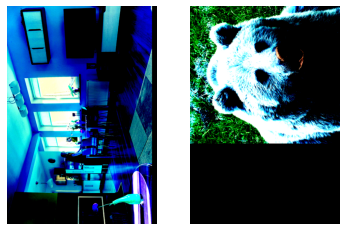

In [10]:
import numpy as np
import matplotlib.pyplot as plt

show_data = next(dataset.create_dict_iterator())

show_images = show_data["img"].asnumpy()
print(f'Image shape: {show_images.shape}') # N*C*H*W

# 展示2张图片供参考
for i in range(1, 3):
    plt.subplot(1, 2, i)

    # 将图片转换HWC格式
    image_trans = np.transpose(show_images[i - 1], (2, 1, 0))
    image_trans = np.clip(image_trans, 0, 1)

    plt.imshow(image_trans[:, :, [2, 1, 0]])
    plt.axis("off")

### 构建网络

![image.png](./md_imgs/network.png)

DETR模型骨干网络采用resnet进行特征提取，使用transformer获取图片全局信息。

### 骨干网络

![resnet](./md_imgs/resnet.png)

DETR模型使用resnet50和resnet101，并且只是用前5个卷积块网络，即conv1，conv2_x, conv3_x, conv4_x, conv5_x。

残差神经网络（ResNet）由微软研究院何凯明等五位华人提出，通过ResNet单元，成功训练152层神经网络，赢得了ILSVRC2015冠军。ResNet前五项的误差率为3.57%，参数量低于VGGNet，因此效果非常显著。传统的卷积网络或全连接网络或多或少存在信息丢失的问题，还会造成梯度消失或爆炸，导致深度网络训练失败，ResNet则在一定程度上解决了这个问题。通过将输入信息传递给输出，确保信息完整性。整个网络只需要学习输入和输出的差异部分，简化了学习目标和难度。ResNet的结构大幅提高了神经网络训练的速度，并且大大提高了模型的准确率。正因如此，ResNet十分受欢迎，甚至可以直接用于ConceptNet网络。

[论文](https://gitee.com/link?target=https%3A%2F%2Farxiv.org%2Fpdf%2F1512.03385.pdf)：Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun."Deep Residual Learning for Image Recognition"

In [5]:
import mindspore.nn as nn
from mindspore import ops

from src.models.position_encoding import PositionEmbeddingSine
from src.models.resnet import resnet50


class Joiner(nn.Cell):
    """
    Joiner architecture.

    Args:
        backbone (Cell): resnet backbone for network.
        position_embedding (Cell): position embedding.

    Returns:
        feature map, mask, position embedding

    Examples:
        >>> backbone = Joiner(resnet, posEmb)
    """

    def __init__(self, backbone, position_embedding, num_channels=2048):
        super(Joiner, self).__init__()
        self.backone = backbone
        self.position_embedding = position_embedding
        self.num_channels = num_channels

    def construct(self, x, mask):
        x = self.backone(x)
        expand_dims = ops.ExpandDims()  # 为了使用resize，对mask进行扩展到4个维度
        squeeze = ops.Squeeze(1)  # 把mask压缩回一个维度
        m = expand_dims(mask, 1)
        pos_emb = []
        mask = []
        for i in x:
            resize = ops.ResizeNearestNeighbor(i.shape[-2:])
            m = resize(m)
            mask.append(squeeze(m))
            p = self.position_embedding(squeeze(m))
            pos_emb.append(p)

        return x, mask, pos_emb  # 返回特征图，mask，位置编码, 都是列表
resnet = resnet50(return_interm_layers=False, is_dilation=False)
posEmb = PositionEmbeddingSine()
backbone = Joiner(resnet, posEmb)

### Transformer

Transformer于2017年提出，用于处理序列数据。Transformer主要应用于自然语言处理（NLP）领域,如机器翻译或文本摘要等任务。不同于传统的循环神经网络按次序处理数据，Transformer采用注意力机制，提高并行，减少训练次数，从而实现在较大数据集上训练。

Transformer具体包括六个编码模块和六个解码模块。每个编码模块由一个自注意层和一个前馈层组成，每个解码模块由一个自注意层，一个编码-解码-注意层和一个前馈层组成。

#### 模型细节

在本案例中使用的transformer虽然和原始的transformer大体上相同，但存在一部分不同。

对于编码器：原始transformer的n个编码器输入中，只有第一个编码器需要输入位置编码向量，但是DETR里面对每个编码器都输入了同一个位置编码向量； QKV处理逻辑不同，在编码器内部位置编码仅仅和 Q、K 相加，V 不做任何处理。

对于解码器：原始transformer顺序解码操作不同的是，DTER一次就把N个无序框并行输出。此外，解码器输入tgt(第一次输入是query embeding，第二次是上一层的输出out);和编码器一样，只是Q与K加上了位置编码信息, V不会加入位置编码；引入可学习的Object queries；不需要顺序解码，一次即可输出N个无序集合。

[论文](https://gitee.com/link?target=https%3A%2F%2Farxiv.org%2Fabs%2F1706.03762): Ashish Vaswani, Noam Shazeer, Niki Parmar, JakobUszkoreit, Llion Jones, Aidan N Gomez, Ł ukaszKaiser, and Illia Polosukhin. 2017. Attention is all you need. In NIPS 2017, pages 5998–6008.

![transformer](./md_imgs/transformer.png)

In [6]:
from mindspore import ops
import mindspore.nn as nn
import mindspore as ms

from src.models.transformer import TransformerEncoderLayer
from src.models.transformer import TransformerEncoder
from src.models.transformer import TransformerDecoderLayer
from src.models.transformer import TransformerDecoder


class Transformer(nn.Cell):
    """transformer 结构"""

    def __init__(self, d_model=256, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", return_intermediate_dec=False):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation)
        encoder_norm = None
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout, activation)
        decoder_norm = nn.LayerNorm((d_model,))
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm,
                                          return_intermediate=return_intermediate_dec)
        self.d_model = d_model
        self.nhead = nhead

    def construct(self, src, mask, query_embed, pos_embed):
        """
        Args:
            src=(WH,N,256), 批次图片特征图
            mask= (N,WH), 批次图片mask
            query_embed, query 位置编码
            pos_embed= (WH,N,256), 图片位置编码
            注释: W=W/32,H=H/32
        """
        # flatten NxCxHxW to HWxNxC
        bs, c, h, w = src.shape
        transpose = ops.Transpose()
        # src=(N,256,W,H)-> (WH,N,256)
        src = transpose(src.view(bs, c, -1), (2, 0, 1))
        # pos_embed=(N,256,W,H)-> (WH,N,256)
        pos_embed = transpose(pos_embed.view(bs, c, -1), (2, 0, 1))
        expand_dims = ops.ExpandDims()
        # query_embed=(100,256) -> (100,N,256), 在decoder中使用
        query_embed = expand_dims(query_embed, 1)
        query_embed = ms.numpy.tile(query_embed, (1, bs, 1))
        mask = ops.Flatten()(mask)  # 把mask展平，mask=(N,W,H) -> (N,WH)

        zeroslike = ops.ZerosLike()
        tgt = zeroslike(query_embed)
        # 输出 (WH,N,256)
        memory = self.encoder(src, src_padding_mask=mask, pos=pos_embed)
        # 输出 hs=(decoder_layers, 100, N, 256)
        hs = self.decoder(tgt, memory, memory_padding_mask=mask,
                          pos=pos_embed, query_pos=query_embed)
        hs = transpose(hs, (0, 2, 1, 3))
        memory = transpose(memory, (1, 2, 0)).view((bs, c, h, w))
        # 输出 hs=(decoder_layers, N, 100, 256)
        return hs, memory

def build_transformer(hidden_dim=256, dropout=0.1, nheads=8, dim_feedforward=2048,
                      enc_layers=6, dec_layers=6, return_intermediate_dec=True):
    """build transformer"""
    return Transformer(
        d_model=hidden_dim,  # 隐藏层维度256
        dropout=dropout,  # 网络丢弃概率，防止过拟合0.1
        nhead=nheads,  # 注意力头数8
        dim_feedforward=dim_feedforward,  # 前向反馈维度2048
        num_encoder_layers=enc_layers,  # 编码器层数6
        num_decoder_layers=dec_layers,  # 解码器层数6
        return_intermediate_dec=return_intermediate_dec,  # 是否返回中间dec
    )
transformer = build_transformer()

### 损失函数

这个端到端的检测模型最后的输出是N个目标的预测框及其分类，这个N是100，比一张图片里面的物体数多很多。使用匈牙利算法能够使得预测出来框能对应到ground truth中的框。然后再计算loss（如公式1），这个loss包括分类的loss和预测框loss（如公式2）。这个预测框loss是giou和L1距离（如公式3）。

$$
\mathcal{L}_{\text {Hungarian }}(y, \hat{y})=\sum_{i=1}^{N}L_{\text {match }}\tag{1}
$$

$$
L_{\text {match }}=L_{object}+L_{box} \tag{2}
$$

$$
\mathcal{L}_{box}=\lambda_{\text {iou }} \mathcal{L}_{\text {iou }}\left(b_{i}, \hat{b}_{\sigma(i)}\right)+\lambda_{\mathrm{L} 1}\left\|b_{i}-\hat{b}_{\sigma(i)}\right\|_{1} \tag{3}
$$

损失函数$L_{match}$由分类损失$L_{object}$和预测框损失$L_{box}$构成。其中$\lambda_{iou}$, $\lambda_{L1}$∈ R是超参数。这两个损失通过批内对象的数量进行规范化。

In [7]:
from src.models.matcher import HungarianMatcher, SetCriterion

num_classes = 91
weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
losses = ['labels', 'boxes', 'cardinality']
hm = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
# 损失函数
criterion = SetCriterion(num_classes, matcher=hm, weight_dict=weight_dict, eos_coef=0.1, losses=losses)

### 模型实现

自定义封装了损失函数和模型网络的类

In [8]:
import mindspore.nn as nn


class CustomWithLossCell(nn.Cell):
    """Connecting the network to the loss function.
    Notes:
        The number of columns in the dataset is not 2, then the forward network
        needs to be connected to the loss function.
    Args:
        net (Cell): Network.
        loss_fn (Cell): Loss function.
    Return:
        loss value.
    """
    def __init__(self, net, loss_fn):
        super(CustomWithLossCell, self).__init__()
        self.net = net
        self._loss_fn = loss_fn

    def construct(self, img, img_mask, img_id, masks, cats,
                  bbox, size, orig_size, iscrowd, area, len_list):
        """net 和 loss结合"""
        # 这行不起作用, 只是避免代码检测报错
        tgt = [img_id, size, orig_size, iscrowd, area]

        output = self.net(img, img_mask)  # 执行前向网络，计算当前输入的损失函数值
        tgt = []
        begin = 0
        for i in range(img.shape[0]):  # 遍历次数==批次
            target = {'labels': cats[0][begin:begin + len_list[i][0]],
                      'boxes': bbox[0][begin:begin + len_list[i][0]],
                      'masks': masks[0][begin:begin + len_list[i][0]]}
            begin += len_list[i][0]
            tgt.append(target)

        # 损失函数
        loss = self._loss_fn(output, tgt)  # loss字典
        weight_dict = self._loss_fn.weight_dict  # 权重字典
        losses = 0
        for k in loss.keys():
            if k in weight_dict:
                losses += loss[k] * weight_dict[k]
        return losses

### 模型训练

In [2]:
import mindspore
from mindspore import context
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor

from src.datasets import coco
from src.models import detr
from src.models import matcher
from src.models.loss import CustomWithLossCell

context.set_context(mode=context.PYNATIVE_MODE, device_target='CPU')

# 加载数据集
dataset = coco.build(img_set='val', batch=1, shuffle=True, coco_dir='../coco')

# 构建模型
print('构建detr网络......')
net = detr.bulid_detr(resnet='resnet50', return_interm_layers=False, num_classes=91, is_dilation=False)

# 优化器
params = []
for p in net.trainable_params():
    if "query_embed" not in p.name:
        params.append(p)
optim = nn.AdamWeightDecay(params=params, learning_rate=1e-3, weight_decay=1e-6)

# 损失函数
criterion = matcher.build_criterion()
net_with_loss = CustomWithLossCell(net, criterion)

# 训练模型
model = mindspore.Model(network=net_with_loss, optimizer=optim)

config_ck = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=5)
ckpoint = ModelCheckpoint(prefix="detr", directory='./checkpoint_detr',
                          config=config_ck)

# Start to train
print('开始训练......')
model.train(1, dataset, callbacks=[ckpoint, LossMonitor(100)], dataset_sink_mode=False)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
构建detr网络......
开始训练......
epoch: 1 step: 100, loss is 8.99109172821045
epoch: 1 step: 200, loss is 4.884150505065918
epoch: 1 step: 300, loss is 3.494307279586792
epoch: 1 step: 400, loss is 5.772262689347069
epoch: 1 step: 500, loss is 5.106029987335205
epoch: 1 step: 600, loss is 5.277222156524658
epoch: 1 step: 700, loss is 5.177199262504776
epoch: 1 step: 800, loss is 5.963103294372559
epoch: 1 step: 900, loss is 4.791848182678223
epoch: 1 step: 1000, loss is 6.733240127563477
epoch: 1 step: 1100, loss is 3.5514445304870605
epoch: 1 step: 1200, loss is 4.81870145882879
epoch: 1 step: 1300, loss is 3.9151451587677
epoch: 1 step: 1400, loss is 5.224384599924088
epoch: 1 step: 1500, loss is 5.161680261790752
epoch: 1 step: 1600, loss is 5.244782327115535
epoch: 1 step: 1700, loss is 5.37483024597168
epoch: 1 step: 1800, loss is 8.088107109069824
epoch: 1 step: 1900, loss is 5.165746180713176
epoch: 1 st

### 模型评估

In [45]:
import os

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


gt = '../coco/annotations/instances_val2017.json'
result_dir = './result'
resnet = 'resnet50'
is_dilation = False

# 判断文件夹是否存在，不存在就创建
if not os.path.exists(result_dir):
    print(f'{result_dir} does not exist! ')
    os.makedirs(result_dir)
else:
    print(f'{result_dir} existed!')

res_file = f'result_{resnet}'
if is_dilation:
    res_file += '_dc'
res_file += '.json'

res_path = os.path.join(result_dir, res_file)
# 判断结果json文件是否存在, 不知则生成结果json文件
if res_file in os.listdir(result_dir):
    # 使用coco api进行评估
    cocoGt = COCO(gt)  # 标注文件的路径及文件名，json文件形式
    cocoDt = cocoGt.loadRes(res_path)  # 自己的生成的结果的路径及文件名，json文件形式
    cocoEval = COCOeval(cocoGt, cocoDt, "bbox")
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
else:
    print(f'{res_path} does not exist!')

./result existed!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Loading and preparing results...
DONE (t=9.69s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=49.89s).
Accumulating evaluation results...
DONE (t=9.55s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.623
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

### 模型推理

DETR是目标检测的网络，网络的输入为（1，3，H，C）的图片张量

In [13]:
from mindspore import load_checkpoint, load_param_into_net

from src.models import detr

net = detr.bulid_detr(resnet='resnet50', return_interm_layers=False, num_classes=91, is_dilation=False)

# 将模型参数存入parameter的字典中，这里加载的是上面训练过程中保存的模型参数
param_dict = load_checkpoint('./resume/resnet50.ckpt')
# 将参数加载到网络中
load_param_into_net(net, param_dict)
print('模型已加载完成!')

模型已加载完成!


./images/000000056288.jpg


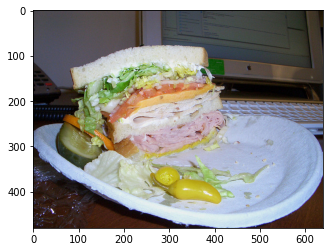

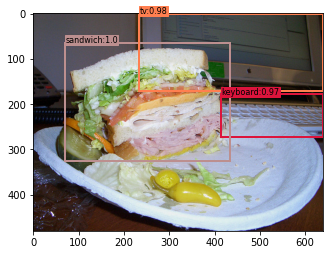

In [42]:
import random
import os

import cv2
import matplotlib.pyplot as plt
import mindspore
from mindspore import nn
import mindspore.dataset.vision.c_transforms as c_vision
from mindspore import context, ops
from mindspore.common.tensor import Tensor


context.set_context(mode=context.PYNATIVE_MODE, device_target='CPU')  # 设置为动态图，静态图有比较多约束

# 随机选择图片
img_dir = './images'
img_name = random.choice(os.listdir(img_dir))
img_path = os.path.join(img_dir, img_name)
print(img_path)
# cv2读取图片
origin_img = cv2.imread(img_path)
b, g, r = cv2.split(origin_img)
origin_img = cv2.merge([r, g, b])
origin_h, origin_w, _ = origin_img.shape
# # 图片预处理
normalize_op = c_vision.Normalize([123.7, 116.3, 103.5], [58.4, 57.1, 57.4])  # 标准化
img = normalize_op(origin_img)

img = Tensor(img)
transpose = ops.Transpose()
img = transpose(img, (2, 0, 1))
img_mask = ops.Zeros()((1, origin_h, origin_w), mindspore.float32)
expand_dims = ops.ExpandDims()
img = expand_dims(img, 0)

outs = net(img, img_mask)
softmax = nn.Softmax()
scores = softmax(outs['pred_logits'][0])

tgts = []
for idx, score in enumerate(scores):
    s_max = score.max(-1)
    if s_max > 0.85:
        img_id = ops.Argmax(-1)(score)
        if img_id < 91:
            box = outs['pred_boxes'][0][idx]
            tgts.append([int(img_id), round(float(s_max), 2), box.asnumpy()])
#             print(idx, img_id, s_max, box)

# 图片可视化
plt.imshow(origin_img)
plt.show()

color_list = ['r', 'rosybrown', 'lightcoral', 'salmon', 'darksalmon', 'coral',
              'y', 'darkorange', 'burlywood', 'tan', 'moccasin', 'orange', 'wheat',
              'g', 'yellowgreen', 'greenyellow', 'lawngreen', 'darkseagreen',
              'b', 'springgreen', 'aquamarine', 'turquoise', 'lightseagreen',
              'c', 'm', 'skyblue', 'lime', 'pink', 'purple', 'indigo', 'plum',
              'orchid', 'hotpink', 'deeppink', 'palevioletred', 'crimson'
              ]

cats_dict = {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
             6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
             11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
             16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow',
             22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack',
             28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee',
             35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat',
             40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket',
             44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife',
             50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich',
             55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza',
             60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant',
             65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop',
             74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave',
             79: 'oven', 80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book',
             85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier',
             }


cat2color = dict()
# 检测框可视化
plt.imshow(origin_img)
for tgt in tgts:
    name = 'unk'
    if tgt[0] in cats_dict.keys():
        name = cats_dict[tgt[0]]  # 根据类别id获取类别名字
    score = tgt[1]
    box = tgt[2].copy()
    box = box*[origin_w, origin_h, origin_w, origin_h]
    box[0] = box[0] - 0.5*box[2]
    box[1] = box[1] - 0.5*box[3]
    if not (box > 0).all():
        continue
    box = list(box)
#     print(tgt[0], name, score, box)

    if name not in cat2color.keys():  # 每个类别只对应一个颜色
        c = random.sample(color_list, 1)[0] # 随机选择颜色
        while c in cat2color.values():  # 保证不同类有不同颜色
            c = random.sample(color_list, 1)[0] # 随机选择颜色
        cat2color[name] = c
    else:
        c = cat2color[name]
    plt.gca().add_patch(plt.Rectangle(xy=(box[0], box[1]), width=box[2], height=box[3], edgecolor=c, fill=False, linewidth=2))#左下角和宽高
    plt.text(box[0], box[1], f'{name}:{score}', fontsize=8, bbox=dict(fc=c, ec=c, pad=0.5)) # 添加文本
plt.show()

### 算法流程

![](./md_imgs/workflow.png)

### 总结

本案例对DETR的论文中提出的模型进行了详细的解释，向读者完整地展现了该算法的流程，分析了DETR作者处理目标检测问题中使用resnet和transformer进行特征提取并输出一系列目标框的过程。

### 引用

[1] Carion N, Massa F, Synnaeve G, et al. End-to-end object detection with transformers[C]//European conference on computer vision. Springer, Cham, 2020: 213-229.

[2] Lin, T.Y., Maire, M., Belongie, S., Hays, J., Perona, P., Ramanan, D., Doll´ar, P.,
Zitnick, C.L.: Microsoft COCO: Common objects in context. In: ECCV (2014)

[2] He, K., Zhang, X., Ren, S., Sun, J.: Deep residual learning for image recognition.
In: CVPR (2016)

[3] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser,
L., Polosukhin, I.: Attention is all you need. In: NeurIPS (2017)